In [1]:
# m vs time for fixed stringlength (m in powers of 2 for table till 1024)

In [2]:
import sympy
import random
import time
from scipy.special import lambertw
import numpy as np


def egcd(a, b):
    x,y, u,v = 0,1, 1,0
    while a != 0:
        q, r = b//a, b%a
        m, n = x-u*q, y-v*q
        b,a, x,y, u,v = a,r, u,v, m,n
    return b, x, y

def mod_inverse(a, m):
    g, x, _ = egcd(a, m)
    if g != 1:
        return None  
    else:
        return x % m

def padding(plain_text,block_size):
    plain_text += '0'*(block_size-len(plain_text))
    return plain_text

def chunkstring(string, length):
    return list(string[0+i:length+i] for i in range(0, len(string), length))

def Rotate(lists, num): # Right is default
    output_list = []       
    for item in range(len(lists) - num, len(lists)): 
        output_list.append(lists[item])       
    for item in range(0, len(lists) - num):  
        output_list.append(lists[item]) 
    return output_list 

def evolve_primes_list(sample,shift_factor):
    right = sample[len(sample)//2+1:]
    left = sample[:len(sample)//2]
    rotated_right = Rotate(right,num=shift_factor%len(right))
    rotated_left = Rotate(left,num=len(left)-(shift_factor%len(left)))
    rotated_left.append(sample[len(sample)//2])
    final = rotated_left + rotated_right
    return final

def calculate_blocksize(n):
    num = int(np.sqrt(n))
    if num**2<n**2:
        return int(np.sqrt(num**2))
    else:
        return(-1)

def get_prime_list_permutations(prime_list,num_blocks):
    primes_list_permutations = []
    for shift_factor in range(num_blocks):
        temp = evolve_primes_list(prime_list,shift_factor%len(prime_list))
        if shift_factor > num_blocks//2:
            temp = temp[:num_blocks//2+shift_factor]
        # print(temp)
        primes_list_permutations.append(temp)
    return primes_list_permutations

In [3]:
m_vals = [1,2,4,8,16,32,64,128,256,512,1024]
time_taken = []

In [4]:
plaintext = 'abcdefghij'*100
blocksize = calculate_blocksize(len(plaintext))
if blocksize%2 == 0:
    blocksize -= 1

print('Blocksize = ',blocksize)

for m in m_vals:
    plain_text_chunks = []
    if len(plaintext) < blocksize:
        plain_text_chunks.append(padding(plaintext,blocksize))
    else:
        chunks = chunkstring(plaintext,blocksize)
        for i in range(len(chunks)):
            plain_text_chunks.append(padding(chunks[i],blocksize))

    ascii_chunks = []
    for chunk in plain_text_chunks:
        t = []
        for i in chunk:
            t.append(ord(i))
        ascii_chunks.append(t)
    num_blocks = len(ascii_chunks)

    # Fixing the value of q based on blocksize using prime number theory
    n = np.exp(-lambertw(-1/blocksize,k=-1))
    n = int(n.real)
    q = sympy.ntheory.generate.nextprime(n,ith=1)

    prime_list = []
    count = 0
    temp = []
    while True:
        if count == blocksize:
            break
        p = sympy.prime(random.randint(1,blocksize))
        if p not in prime_list and mod_inverse(p,q**m)!=None:
            prime_list.append(p)
            count += 1

    prime_list_permutations = get_prime_list_permutations(prime_list,num_blocks)

    t1 = time.time()

    encrypted_cipher = []
    for chunk in range(len(ascii_chunks)):
        cipher = []
        for c in range(len(ascii_chunks[chunk])):
            cipher.append((ascii_chunks[chunk][c]*prime_list_permutations[chunk][c])%(q**m))
        encrypted_cipher.append(cipher)

    decrypted_ascii_chunks = []
    for chunk in range(len(encrypted_cipher)):
        temp_ascii = []
        for k in range(len(encrypted_cipher[chunk])):
            temp_ascii.append((encrypted_cipher[chunk][k]*mod_inverse(prime_list_permutations[chunk][k],q**m))%q**m)
        decrypted_ascii_chunks.append(temp_ascii)

    decrypted_text_list = []
    for chunk in decrypted_ascii_chunks:
        for i in chunk:
            if chr(i)!='0':
                decrypted_text_list.append(chr(i))
    tt = time.time()-t1
    time_taken.append(tt)
    print('m = '+ str(m) + ' -------------- Operation Runtime : {} seconds'.format(tt))

Blocksize =  31
m = 1 -------------- Operation Runtime : 0.0018422603607177734 seconds
m = 2 -------------- Operation Runtime : 0.001878976821899414 seconds
m = 4 -------------- Operation Runtime : 0.002119779586791992 seconds
m = 8 -------------- Operation Runtime : 0.002096414566040039 seconds
m = 16 -------------- Operation Runtime : 0.0022907257080078125 seconds
m = 32 -------------- Operation Runtime : 0.002521991729736328 seconds
m = 64 -------------- Operation Runtime : 0.0029687881469726562 seconds
m = 128 -------------- Operation Runtime : 0.003992319107055664 seconds
m = 256 -------------- Operation Runtime : 0.006209373474121094 seconds
m = 512 -------------- Operation Runtime : 0.012920141220092773 seconds
m = 1024 -------------- Operation Runtime : 0.03332209587097168 seconds


Text(0, 0.5, 'Runtime (seconds)')

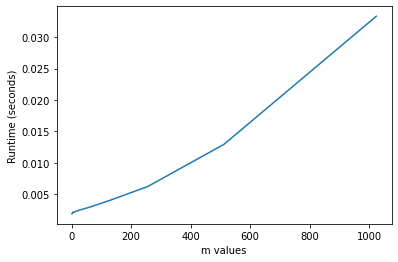

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(m_vals, time_taken)
plt.xlabel('m values')
plt.ylabel('Runtime (seconds)')